In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from urllib.parse import quote, unquote
from bs4 import BeautifulSoup
from collections import Counter
import seaborn as sns
from statistics import mean
from matplotlib.colors import LogNorm

### Reading the data into dataframes

In [2]:
articles = pd.read_csv('wikispeedia_paths-and-graph/articles.tsv', comment='#', delimiter='\t', encoding='utf8', 
                                    names=['article'])
categories = pd.read_csv('wikispeedia_paths-and-graph/categories.tsv', comment='#', delimiter='\t',
                                    names=['article', 'category'])
links = pd.read_csv('wikispeedia_paths-and-graph/links.tsv', comment='#', delimiter='\t', 
                                    names=['article', 'linkTarget'])  
finished_paths = pd.read_csv('wikispeedia_paths-and-graph/paths_finished.tsv', comment='#', delimiter='\t', 
                                    names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating'])
unfinished_paths = pd.read_csv('wikispeedia_paths-and-graph/paths_unfinished.tsv', comment='#', delimiter='\t',
                                    names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'target', 'type'])

Apply decoding on articles

Note: article names stored in df are decdoed but with underscores (_) instead of spaces ( )

In [3]:
articles['article'] = articles['article'].apply(unquote) # unquote to decode the article names
categories['article'] = categories['article'].apply(unquote)
links = links.applymap(unquote)
links.head(5)

,article,linkTarget
0,Áedán_mac_Gabráin,Bede
1,Áedán_mac_Gabráin,Columba
2,Áedán_mac_Gabráin,Dál_Riata
3,Áedán_mac_Gabráin,Great_Britain
4,Áedán_mac_Gabráin,Ireland


For every article, "links" stores all the articles it outlinks in a dataframe. Every row can be interpreted as containing a directed edge from the entry in column "article" to the entry in column "linkTarget".

"links22" is an updated version of "links" where the articles used are from 2022

In [4]:
links22 = pd.read_csv('Wiki_2022/links22.tsv', comment='#', delimiter='\t', names=['article', 'linkTarget']).applymap(unquote)
links22.head()

,article,linkTarget
0,linkSource,linkTarget
1,Áedán_mac_Gabráin,Columba
2,Áedán_mac_Gabráin,Isle_of_Man
3,Áedán_mac_Gabráin,Genealogy
4,Áedán_mac_Gabráin,Bede


In [5]:
# Set indices
articles.set_index('article', inplace=True)
categories.set_index('article', inplace=True)
finished_paths.set_index('hashedIpAddress', inplace=True)
unfinished_paths.set_index('hashedIpAddress', inplace=True)

In [6]:
# Create df with all paths
paths_combined = pd.concat([finished_paths, unfinished_paths])
paths_combined.head(5)
print(len(finished_paths.index))

51318


In [7]:
# Filter out all paths with <
finished_paths_with_back = finished_paths.loc[finished_paths.path.str.contains('<')]

def get_associated_articles(path):
    article_list = path.split(';')
    index = article_list.index('<')
    return article_list[index-1], article_list[index+1]
    
# Add columns of associated articles before and after <
# TODO: get rid of warnings
finished_paths_with_back['article1'], finished_paths_with_back['article2'] = \
    zip(*finished_paths_with_back['path'].map(get_associated_articles))
finished_paths_with_back.head(5)

/var/folders/d_/jkyqhpjj7yn2z5jb4v43zkjw0000gn/T/ipykernel_66863/3853467544.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finished_paths_with_back['article1'], finished_paths_with_back['article2'] = \
/var/folders/d_/jkyqhpjj7yn2z5jb4v43zkjw0000gn/T/ipykernel_66863/3853467544.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finished_paths_with_back['article1'], finished_paths_with_back['article2'] = \


,timestamp,durationInSec,path,rating,article1,article2
hashedIpAddress,,,,,,
4cb0068c36658716,1248654953,253,14th_century;Time;Science;Nature;Weather;Sunli...,3.0,Sunlight,Sun
0d57c8c57d75e2f5,1283956474,391,14th_century;Renaissance;Empiricism;Nature;Wea...,5.0,Sunlight,Rain
0d57c8c57d75e2f5,1290753904,432,14th_century;Renaissance;Leonardo_da_Vinci;Wat...,NaN,Cloud,<
03dc907932cecfc5,1336436263,387,14th_century;Europe;Republic_of_Ireland;<;<;Eu...,2.0,Republic_of_Ireland,<
46021cc81bd7069a,1343940479,246,14th_century;Time;Physics;<;Day;Sun;Sunlight;U...,NaN,Physics,Day


In [8]:
print(f"Number of finished paths containing a back-edge: {len(finished_paths_with_back.index)}")

Number of finished paths containing a back-edge: 8995


In [9]:
# Functions for accessing article data
# Return a list containing plaintext content of wikipedia article
def get_plaintext(name):
    file_path = 'plaintext_articles/' + quote(name) + '.txt'
    with open(file_path, encoding='utf-8') as file:
        #first 5 lines are comments and titles 
        lines = file.readlines()[5:] 
        return list(map(str.strip, lines))

# Return prettified html content of wikipedia article
def get_html(name):
    file_path = 'wpcd/wp/' + name[0] + '/' + quote(name) + '.htm'
    with open(file_path) as file:
        html_doc = file.read()
        soup = BeautifulSoup(html_doc, 'html.parser')
        return soup.prettify()

# Exploratory Data Analysis

In [10]:
# Exploratory Data Analysis
n_articles = len(articles)
print(f'The number of articles is: {n_articles}')


The number of articles is: 4604


## Distributions of Data

### Incoming and Outgoing edges in Wikipedia

In [11]:
def edge_distributions(edges, incoming=True, old=True):
    '''
    Plots the distributions of the number of incoming/outgoing edges for each article for the 2009 and 2022 datasets.
    
    :param edges: dataframe containing number of edges (either incoming or outgoing)
    :param incoming: boolean, True if incoming edges, False if outgoing edges
    :param old: boolean, True if old dataset, False if new dataset
    '''
    articles_edges = (articles.copy(deep=True).join(edges).fillna(0))

    if incoming:
        articles_edges_lt = articles_edges.article
    else:
        articles_edges_lt = articles_edges.linkTarget
    mean_links = articles_edges_lt.mean()
    max_links = articles_edges_lt.max()
    num_leaves = (articles_edges_lt == 0).sum()
    if old:
        print(f'The mean number of inlinks is: {mean_links:.2f}')
        print(f'The maximum number of inlinks on any page is: {max_links}. This is the article on {articles_edges_lt[articles_edges_lt==max_links].index[0]}.')
        print(f'The number of pages without any inlinks is: {num_leaves}')
    else:
        print(f'The mean number of inlinks in 2022 is: {mean_links:.2f}')
        print(f'The maximum number of inlinks in 2022 on any page is: {max_links}. This is the article on {articles_edges_lt[articles_edges_lt==max_links].index[0]}.')
        print(f'The number of pages without any inlinks in 2022 is: {num_leaves}')


    bins = [i for i in range(int(max(articles_edges_lt)+1))]
    return articles_edges, bins

### Inlinks
Distibutions of inlinks, original vs 2022

The mean number of inlinks is: 26.04
The maximum number of inlinks on any page is: 1551.0. This is the article on United_States.
The number of pages without any inlinks is: 469
The mean number of inlinks in 2022 is: 49.43
The maximum number of inlinks in 2022 on any page is: 1064.0. This is the article on United_States.
The number of pages without any inlinks in 2022 is: 467


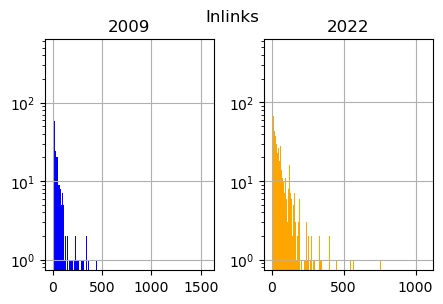

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
plt.suptitle('Inlinks')
art1, bins1 = edge_distributions(links.groupby(['linkTarget'])['article'].count(), True)
art2, bins2 = edge_distributions(links22.groupby(['linkTarget'])['article'].count(), True, False)
art1.hist(bins=bins1, ax=axes[0], log=True, color='blue' ,label='2009')
art2.hist(bins=bins2, ax=axes[1], log=True, color='orange', label='2022')
axes[0].set_title('2009')
axes[1].set_title('2022')
plt.show()

The mean number of inlinks is: 26.04
The maximum number of inlinks on any page is: 294.0. This is the article on United_States.
The number of pages without any inlinks is: 17
The mean number of inlinks in 2022 is: 49.43
The maximum number of inlinks in 2022 on any page is: 367.0. This is the article on Europe.
The number of pages without any inlinks in 2022 is: 11


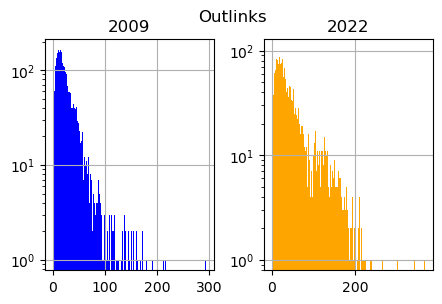

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
plt.suptitle('Outlinks')
art1, bins1 = edge_distributions(links.groupby(['article'])['linkTarget'].count(), False)
art2, bins2 = edge_distributions(links22.groupby(['article'])['linkTarget'].count(), False, False)
art1.hist(bins=bins1, ax=axes[0], log=True, color='blue' ,label='2009')
art2.hist(bins=bins2, ax=axes[1], log=True, color='orange', label='2022')
axes[0].set_title('2009')
axes[1].set_title('2022')
plt.show()

We have used log axes to plot the distributions since the distributions are heavily skewed to the right. The distributions are also similar, but we can see that in general pages got more inlinks as well as outlinks in 2022.

### Categories
For our analysis, we have decided to use 15 categories. These categories are general enough to allow us to interpret them but at the same time specific enough to allow us to do a meaningful analysis.

In [14]:
# The main categories that we are interested in (we have chosen these ourselves)
wiki_2009_categories = pd.read_csv('./wikispeedia_paths-and-graph/categories.tsv', delim_whitespace=True, names=['article', 'category'], comment='#')

# When articles have more than one main category, we choose to sample one.
# This is perhaps not an optimal method, but it is currently the best we can think of.
wiki_2009_categories = wiki_2009_categories.groupby('article').sample(1)
wiki_2009_categories['category'] = wiki_2009_categories['category'].str.extract(r'subject\.([a-zA-Z]*)')
wiki_2009_categories = wiki_2009_categories.set_index('article')
article_cat = wiki_2009_categories.to_dict()['category']

### Getting Intimate with the Data
We want to see how many articles are in each category

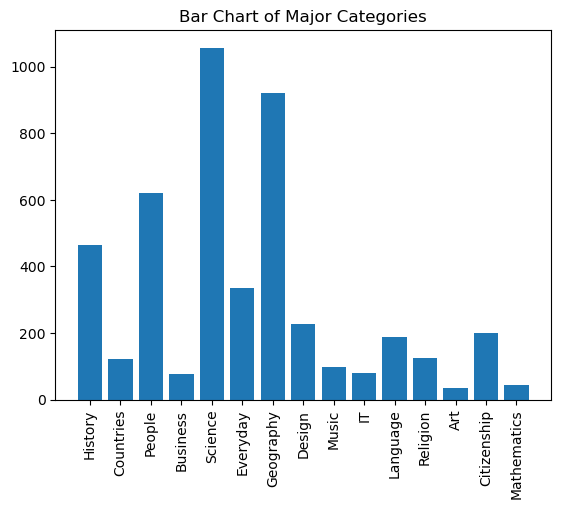

In [15]:
labels, values = zip(*Counter(article_cat.values()).items())
indexes = np.arange(len(labels))
width = 0.8

plt.bar(indexes, values, width)
plt.xticks(indexes, labels, rotation=90)
plt.title("Bar Chart of Major Categories")
plt.show()

Converting the articles to categories in the links dataframe

In [16]:
cats_df = links.copy(deep=True)
cats_df['article'] = cats_df['article'].apply(lambda x: article_cat[x] if x in article_cat else 'NA') 
cats_df['linkTarget'] = cats_df['linkTarget'].apply(lambda x: article_cat[x] if x in article_cat else 'NA') 
cats_df.head()

,article,linkTarget
0,NA,History
1,NA,People
2,NA,NA
3,NA,History
4,NA,Geography


Computing the adjacency matrix when the articles are converted to categories

In [17]:
cats_df.groupby(['article', 'linkTarget']).size().unstack(fill_value=0)

linkTarget,Art,Business,Citizenship,Countries,Design,Everyday,Geography,History,IT,Language,Mathematics,Music,NA,People,Religion,Science
article,,,,,,,,,,,,,,,,
Art,111,7,23,71,31,29,148,135,3,55,3,13,29,157,55,54
Business,5,289,153,401,52,63,633,114,19,28,11,1,35,77,20,138
Citizenship,25,156,1063,1041,69,187,1672,643,40,190,22,12,156,569,222,299
Countries,25,245,602,1272,49,240,2389,539,13,273,8,40,164,201,221,236
Design,38,57,115,488,399,98,1166,374,46,53,10,9,178,230,46,400
Everyday,40,66,230,1084,72,1139,1949,448,110,329,21,39,225,281,125,1091
Geography,103,560,1518,4215,426,1138,11896,2216,40,941,30,120,899,944,650,2098
History,59,153,783,1623,249,282,3456,2956,28,345,36,32,313,1402,456,689
IT,0,37,27,50,31,34,81,10,371,52,23,5,40,53,1,50


<AxesSubplot:xlabel='linkTarget', ylabel='article'>

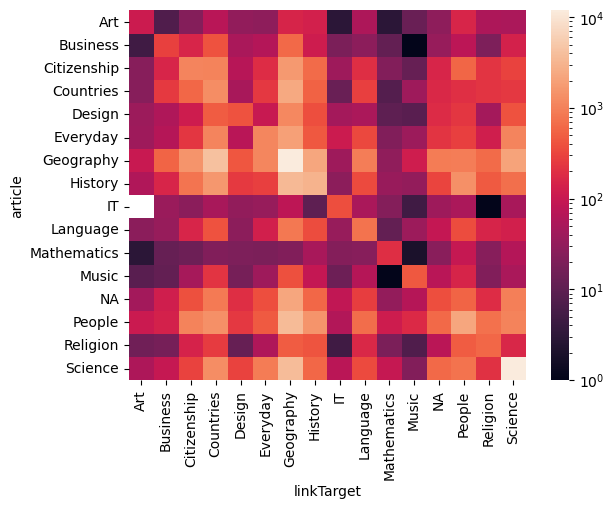

In [18]:
sns.heatmap(data=cats_df.groupby(['article', 'linkTarget']).size().unstack(fill_value=0), norm=LogNorm())

### Some Observations
1) *The Geography row is on average lighter than the Design row:*
This makes sense because the Geography row is more likely to be used by a player since it is easiest to think of when traversing from one page to the other, the player anticipates their next moves to be easier with this.

2) *Design to Geography has a darker colour than Geography to Design:*
This makes sense since people would move from Design, which is a domain with fewer and less natural connections to other categories, to Geography, a domain with many natural connections to other categories, but not the other way around

### Category-Wise Analysis
We check things like-
1. How many articles are there in each category?
2. Number of inlinks and outlinks for each category

In [19]:
# Return list of all articles in a category
def cat_wise(cats_link, cat):
    cats_link = cats_link[cats_link['category'] == cat].index
    return list(cats_link)

In [20]:
def get_plaintext(name):
    file_path = './plaintext_articles/' + name + '.txt'
    with open(file_path, encoding='utf-8') as file:
        #first 5 lines are comments and titles 
        lines = file.readlines()[5:] 
        return list(map(str.strip, lines))

def cat_wise_stats(cats_link, cat):
    titles = cat_wise(wiki_2009_categories, cat)
    word_count_ls = []

    for title in titles:
        word_count= sum([len(l.split()) for l in get_plaintext(title)])
        word_count_ls.append(word_count)

    inc = links.groupby(['linkTarget'])['article'].count()
    out = links.groupby(['article'])['linkTarget'].count()
    filt_inc = inc[[x in article_cat and article_cat[x] == cat for x in inc.index]]
    filt_out = out[[x in article_cat and article_cat[x] == cat for x in out.index]]
    avg_words = mean(word_count_ls)
    avg_in = filt_inc.mean()
    avg_out = filt_out.mean()
    print(f'The average number of words in a wikipedia article for category "{cat}" is: {avg_words:.2f}')
    print(f'The average number of inlinks for category "{cat}" is: {avg_in:.2f}')
    print(f'The average number of outlinks for category "{cat}" is: {avg_out:.2f}')
    print(f'The average number of words per inlink for category "{cat}" is: {avg_words/avg_in:.2f}')
    print(f'The average number of words per outlink for category "{cat}" is: {avg_words/avg_out:.2f}')

### Category-Wise Analysis

**Design**

In [21]:
cat_wise_stats(links, 'Design')

The average number of words in a wikipedia article for category "Design" is: 2991.55
The average number of inlinks for category "Design" is: 12.93
The average number of outlinks for category "Design" is: 17.91
The average number of words per inlink for category "Design" is: 231.38
The average number of words per outlink for category "Design" is: 167.05


**Geography**

In [22]:
cat_wise_stats(links, 'Geography')


The average number of words in a wikipedia article for category "Geography" is: 2959.55
The average number of inlinks for category "Geography" is: 44.37
The average number of outlinks for category "Geography" is: 33.98
The average number of words per inlink for category "Geography" is: 66.70
The average number of words per outlink for category "Geography" is: 87.10


In [23]:
print(f"2009 dataset total links: {len(links)} \n2022 dataset total links: {len(links22)}")

2009 dataset total links: 119882 
2022 dataset total links: 227581


In [24]:
# Any missing values?
print("Missing values: ", links.article.isna().sum())
print("Missing values: ", links22.article.isna().sum())
print("Missing values: ", links.linkTarget.isna().sum())
print("Missing values: ", links22.linkTarget.isna().sum())

Missing values:  0
Missing values:  0
Missing values:  0
Missing values:  0


### Number of words in the articles 
We want to examine the number of words in the articles to get a better understandign of the dataset. Additionally we want to know how the number of links correlate with the number of links and what the relationship between number of links and number of words look like. 

In [25]:
# Count the number of words in each article
ls_articles09 = links.article.unique()
ls_articles22 = links22.article.unique()

word_count_ls = []
for article in ls_articles09:
    word_count= sum([len(l.split()) for l in get_plaintext(quote(article))])
    word_count_ls.append(word_count)

Longest article: 16348 words 
Shortest article: 100 words 
Median length: 2653.0


Text(0, 0.5, 'Frequency')

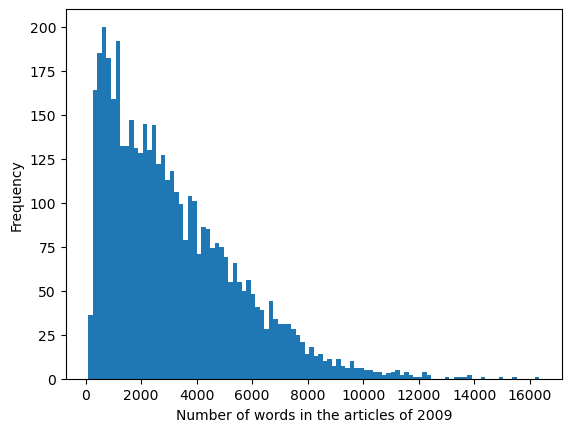

In [26]:
# Plot histogram over number of words per article
import matplotlib.pyplot as plt

print(f"Longest article: {max(word_count_ls)} words \nShortest article: {min(word_count_ls)} words \nMedian length: {np.median(word_count_ls)}")

plt.hist(word_count_ls, bins=100)
plt.xlabel("Number of words in the articles of 2009")
plt.ylabel("Frequency")

In [27]:
# Words over number of links. The articles are ordered the same in the word_count_ls as in links dataframe
word_count_na = np.array(word_count_ls)
links_of_articles = [item for sublist in links.groupby(links.article).count().values for item in sublist]
words_over_links = word_count_na/links_of_articles

Max word/link ratio: 7434.0


Text(0.5, 0, 'Words over links per article')

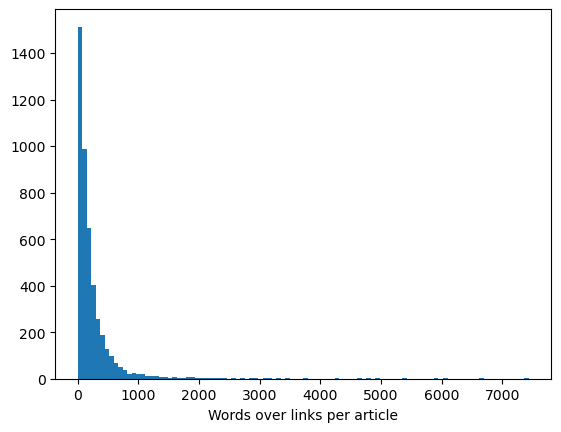

In [28]:
print(f"Max word/link ratio: {max(words_over_links)}")
plt.hist(words_over_links, bins=100)
plt.xlabel("Words over links per article")

### Correlations
We need to create lists with counts of each article for both columns in the dataset using the below methodology seperatly. This is because there are more unique articles in the article column than in the linkTarget column. Therefore, in a case where an article which exist in the article column does not exist in the linkTarget column, we append a 0.

In [29]:
# incomming vs outgoing 2009
unique_articles = links.article.unique()
unique_target = set(links.linkTarget.unique())
outgoing = []
incomming = []

for article in unique_articles:
    outgoing.append(links.article.value_counts()[article])

for article in unique_articles:
    if article in unique_target:
        incomming.append(links.linkTarget.value_counts()[article])
    else:
        incomming.append(0)

In [30]:
# incomming vs outgoing 2022
unique_articles22 = links22.article.unique()
unique_target22 = set(links22.linkTarget.unique())
outgoing22 = []
incomming22 = []

for article in unique_articles22:
    outgoing22.append(links22.article.value_counts()[article])

for article in unique_articles22:
    if article in unique_target22:
        incomming22.append(links22.linkTarget.value_counts()[article])
    else:
        incomming22.append(0)

In [31]:
# Word Count vs Number of links per article
print(f"2009 Correlation 'word count', 'words over links': {round(np.corrcoef(words_over_links, word_count_ls)[0,1],1)}")

# Incomming vs outgoing 2009
print(f"2009 Correlation 'outgoing links', 'incomming links': {round(np.corrcoef(outgoing, incomming)[0,1], 3)}")

# Incomming vs outgoing 2022 
print(f"2022 Correlation 'outgoing links', 'incomming links': {round(np.corrcoef(outgoing22, incomming22)[0,1], 3)}")

2009 Correlation 'word count', 'words over links': 0.4
2009 Correlation 'outgoing links', 'incomming links': 0.542
2022 Correlation 'outgoing links', 'incomming links': 0.717


Interesting observation: correlation between incomming and outgoing links for each article got stronger between 2009 and 2022. 

## Graph Analysis

In [32]:

import pandas as pd
import networkx as nx
from node2vec import Node2Vec
import matplotlib.pylab as plt
import seaborn as sns
import os
import gensim
import umap

### Loading in the data

In [33]:
# Load in the link data
links_2009 = pd.read_csv('./wikispeedia_paths-and-graph/links.tsv', delim_whitespace=True, names=['from', 'to'], comment='#')
links_2022 = pd.read_csv('./wikispeedia_paths-and-graph/links22.tsv', delim_whitespace=True, comment='#')

# Load in the path data of finished games
wikispeedia_paths = pd.read_csv('./wikispeedia_paths-and-graph/paths_finished.tsv', delim_whitespace=True,\
    names=['hashed_ip', 'timestamp', 'duration_sec', 'path', 'rating'], comment='#')

wikispeedia_paths.head()

,hashed_ip,timestamp,duration_sec,path,rating
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0


### Constructing the graphs

In [34]:
# Construct the directed graph for 2009 by adding all links as edges
graph_2009 = nx.DiGraph()

for l, r in links_2009.iterrows():
    graph_2009.add_edge(r['from'], r['to'])

print(f"The graph from 2009 has {graph_2009.number_of_nodes()} nodes and {graph_2009.number_of_edges()} edges")

The graph from 2009 has 4592 nodes and 119882 edges


In [35]:
# Construct the directed graph for 2022 by adding all links as edges
graph_2022 = nx.DiGraph()

for l, r in links_2022.iterrows():
    graph_2022.add_edge(r['linkSource'], r['linkTarget'])

print(f"The graph from 2022 has {graph_2022.number_of_nodes()} nodes and {graph_2022.number_of_edges()} edges")

The graph from 2022 has 4593 nodes and 227580 edges


While the previous two graphs are unweighted, we choose here to construct a weighted graph for the wikispeedia path graph. We opt to do this as it is more inline the idea of certain links having more importance following "human intuition". Specifically, the weight of each edge is the number of wikispeedia paths that pass through it.

Currently we only add edges from finished paths. We will look into potentially adding unfinished paths as well.

In [36]:
graph_wikispeedia_paths = nx.DiGraph()

for l, r in wikispeedia_paths.iterrows():
    path = r['path'].split(';')
    for i in range(len(path)-1):
        # If the edge already exists, increment the weight.
        if graph_wikispeedia_paths.has_edge(path[i], path[i+1]):
            graph_wikispeedia_paths[path[i]][path[i+1]]['weight'] += 1
        else:
            graph_wikispeedia_paths.add_edge(path[i], path[i+1], weight=1)

print(f"The graph constructed from the finished paths has {graph_wikispeedia_paths.number_of_nodes()}"
      f" nodes and {graph_wikispeedia_paths.number_of_edges()} edges")

The graph constructed from the finished paths has 4170 nodes and 55147 edges


### Creating the node embeddings with node2vec
The embeddings created here serve as a starting point for further qualitative and quantitative analysis. The hyperparameters chosen are done so according to only a small bit of testing. More specifically, the parameters that we might change are the number of embedding dimension $d=128$, the random walk length, and the number of walks. Walk length has tentatively been set to 10 as it is slightly more than wikispeedia path lengths, and seems to yield good clustering in the subsequent embedding graphs.

In [37]:
def get_embedding_model(path, graph):
    """ 
    Attempts to load model from path if model exists, otherwise trains one
    annew using `graph` and saves it.
    """

    if os.path.isfile(path):
        model = gensim.models.word2vec.Word2Vec.load(path)
    else:
        n2v = Node2Vec(graph, dimensions=128, walk_length=10, num_walks=2000, workers=8)
        model = n2v.fit()
        model.save(path)
    
    return model

MODEL_PATH_2009 = './models/n2v_2009.model'
MODEL_PATH_2022 = './models/n2v_2022.model'
MODEL_PATH_WIKISPEEDIA_PATHS = './models/n2v_wikispeedia_paths.model'

In [38]:
# Get all the embeddings for the analysis
model_2009 = get_embedding_model(MODEL_PATH_2009, graph_2009)
model_2022 = get_embedding_model(MODEL_PATH_2022, graph_2022)
model_wikispeedia_paths = get_embedding_model(MODEL_PATH_WIKISPEEDIA_PATHS, graph_wikispeedia_paths)

### Visualizing the embeddings in low-dimensional space with UMAP
#### Visualizing according to categories

Text(0.5, 1.0, 'Distribution of number of base categories over all articles')

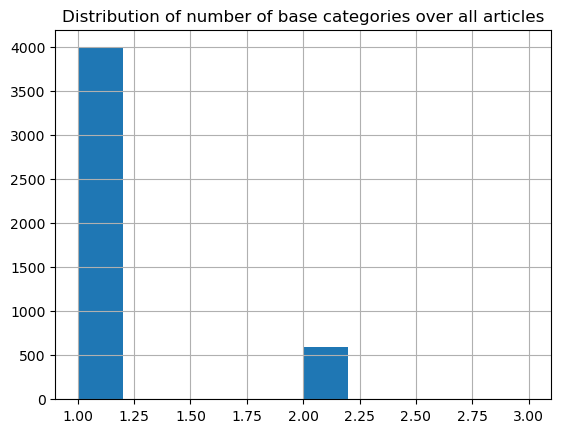

In [39]:
# Read in the categories for each article and extract the highest level category.
# I.e. Science if the category is subject.Science.Chemistry
wiki_2009_categories = pd.read_csv('./wikispeedia_paths-and-graph/categories.tsv', delim_whitespace=True, \
    names=['article', 'category'], comment='#')
wiki_2009_categories.groupby('article').count().hist()
plt.title('Distribution of number of base categories over all articles')

Here we can see that a not insignificant minority of articles have two main categories, so we may have to deal with this in a better way in the future.

In [40]:
# Helper function for finding the correct categories for each embedding
# in the node2vec models.
def map_categories(model, article_2_cat):
    cat = []
    for k in model.wv.key_to_index.keys():
        if k in article_2_cat:
            cat.append(article_2_cat[k])
        else:
            cat.append("NA")

    return cat

# Helper function for plotting neat embedding graphs.
def plot_embedding(embedding, cat, title):
    palette = {k:v for (k, v) in zip(set(cat), sns.color_palette('tab20'))}
    sns.set(rc={'figure.figsize':(8,8)})
    ax = sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], size=1, data=pd.DataFrame({'category':cat}), hue='category', palette=palette)
    handles, labels = plt.gca().get_legend_handles_labels()
    tmp = sorted(list(zip(handles, labels)), key=lambda x: x[1])[1:]
    plt.legend([x[0] for x in tmp],[x[1] for x in tmp])
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


In [41]:
# Use UMAP to find an appropriate low-dim projection
reducer = umap.UMAP()
embedding_2009 = reducer.fit_transform(model_2009.wv.get_normed_vectors())

reducer = umap.UMAP()
embedding_2022 = reducer.fit_transform(model_2022.wv.get_normed_vectors())

reducer = umap.UMAP()
embedding_wikispeedia_paths = reducer.fit_transform(model_wikispeedia_paths.wv.get_normed_vectors())

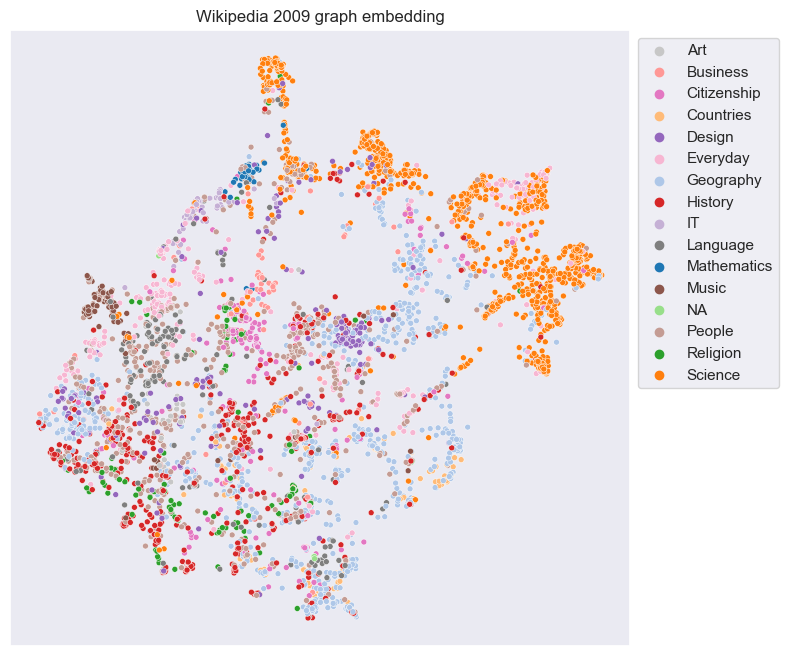

In [42]:
cat = map_categories(model_2009, article_cat)
plot_embedding(embedding_2009, cat, 'Wikipedia 2009 graph embedding')

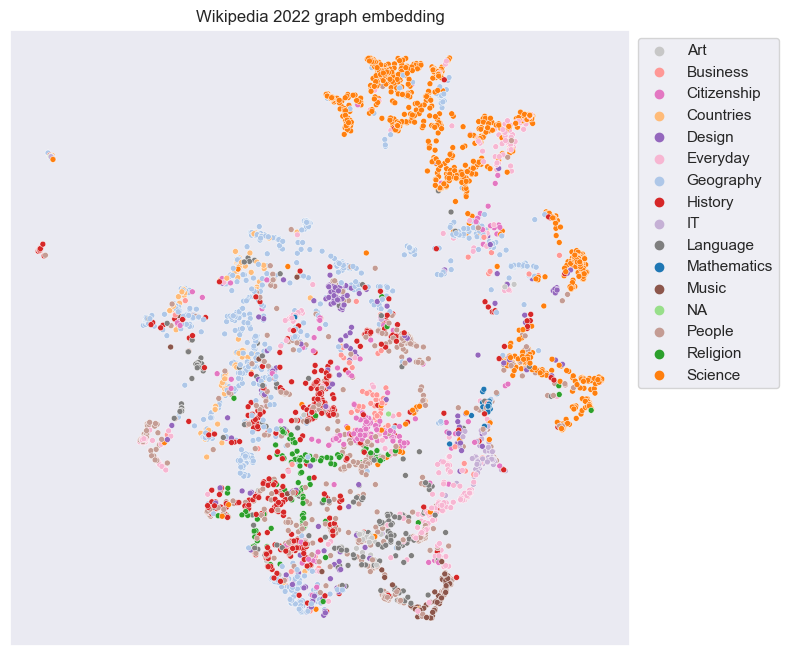

In [43]:
cat = map_categories(model_2022, article_cat)
plot_embedding(embedding_2022, cat, 'Wikipedia 2022 graph embedding')

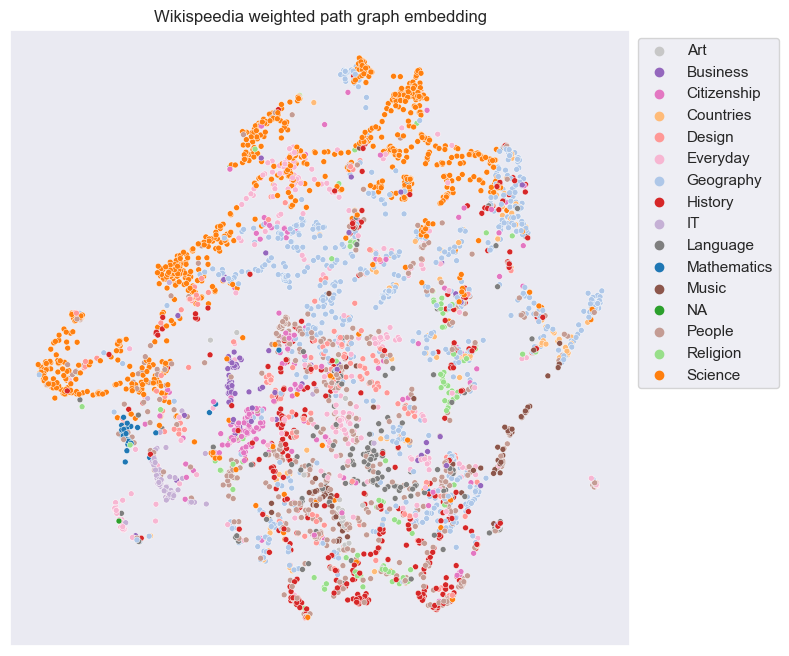

In [44]:
cat = map_categories(model_wikispeedia_paths, article_cat)
plot_embedding(embedding_wikispeedia_paths, cat, 'Wikispeedia weighted path graph embedding')

**Analysis:**
Comparing the three graphs we can see that there are some really interesting category clusterings. Science seems to be a very large part of the corpus for example. We can also see that the Mathematics and IT clusters end up close to each other, nearby the one end of the science cluster. Looking closer at the differences between wikispeedia and the other two we can see that from visual analysis, the wikispeedia graph exibits less tight local clustering with some categories fragmented to a larger extent. Specifically, we observe that some categories like Science, IT continue to be relatively tightly linked, while others that are more general such as Geography and Countries are more scattered.

#### Visualizing according to hub and authority categorization
In this part we use the HITS algorithm to figure out if articles are hubs or authorities. An article that is a hub is one that has many outgoing links to authorities, and an article that is an authority has many incoming links from hubs. We choose here to not modify any of the hyperparameters of the HITS algorithm and leave them at their library defaults. Specifically, we here classify an article as a hub if it has a higher hub-score and vice versa.

In [45]:
def hits_categorize(graph):
    graph_hits = nx.hits(graph)

    graph_2_hits_cat = {}
    for (k1, v1), (k2, v2) in zip(graph_hits[0].items(), graph_hits[1].items()):
        if v1 > v2:
            graph_2_hits_cat[k1] = 'hub'
        else:
            graph_2_hits_cat[k1] = 'authority'
    
    return graph_2_hits_cat


/Users/riko/miniconda3/envs/ada/lib/python3.9/site-packages/networkx/algorithms/link_analysis/hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)


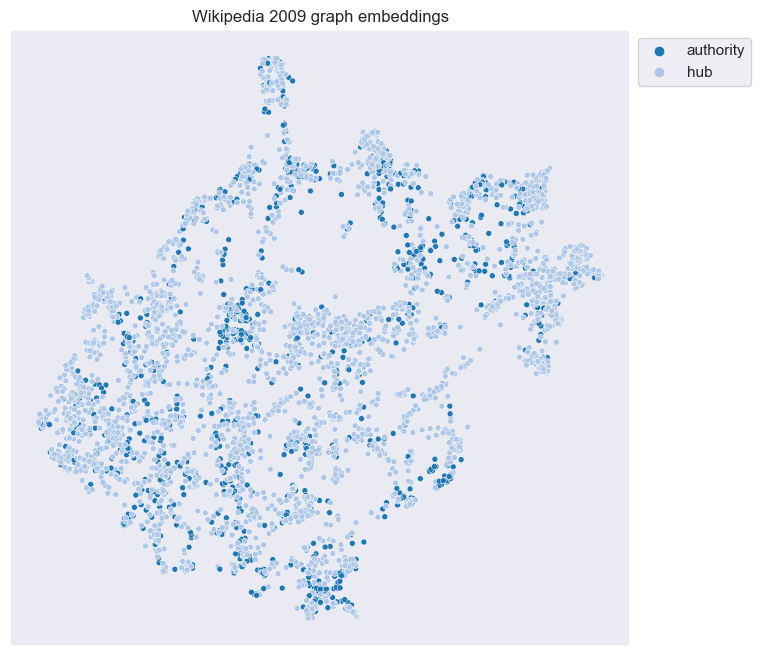

In [46]:
wiki_2009_2_hits = hits_categorize(graph_2009)
cat = map_categories(model_2009, wiki_2009_2_hits)
plot_embedding(embedding_2009, cat, 'Wikipedia 2009 graph embeddings')

/Users/riko/miniconda3/envs/ada/lib/python3.9/site-packages/networkx/algorithms/link_analysis/hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)


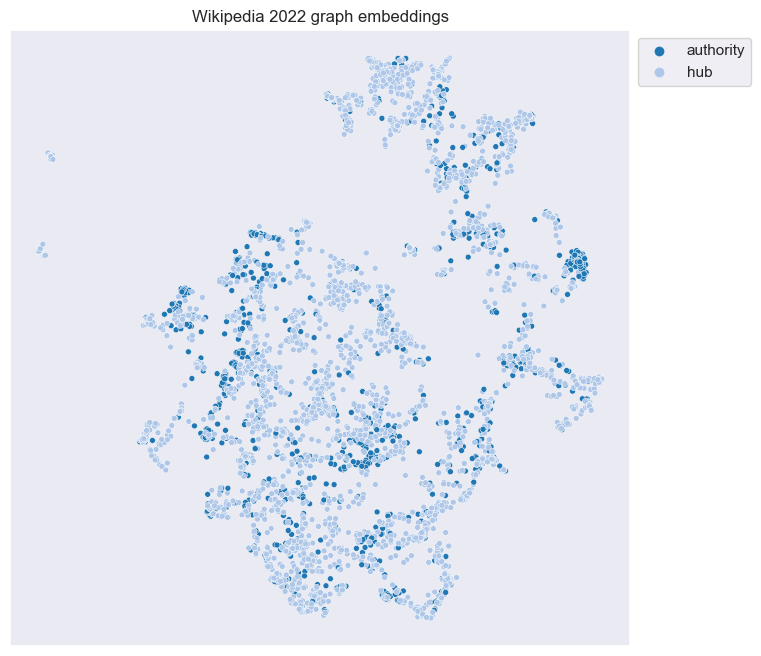

In [47]:
wiki_2022_2_hits = hits_categorize(graph_2022)
cat = map_categories(model_2022, wiki_2022_2_hits)
plot_embedding(embedding_2022, cat, 'Wikipedia 2022 graph embeddings')

/Users/riko/miniconda3/envs/ada/lib/python3.9/site-packages/networkx/algorithms/link_analysis/hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)


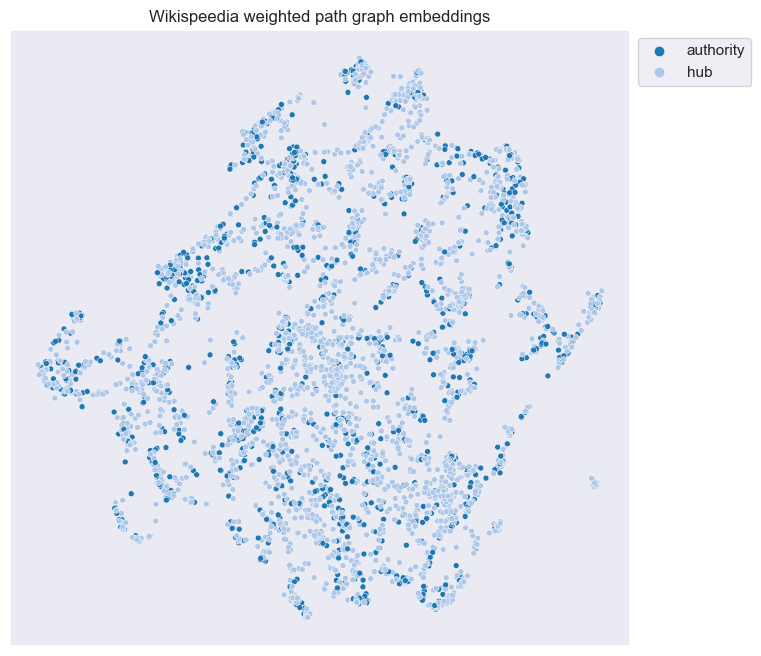

In [48]:
wikispeedia_2_hits = hits_categorize(graph_wikispeedia_paths)
cat = map_categories(model_wikispeedia_paths, wikispeedia_2_hits)
plot_embedding(embedding_wikispeedia_paths, cat, 'Wikispeedia weighted path graph embeddings')

**Analysis:**
A tentative qualitative analysis shows that the embedding projections generated from the actual 2009 and 2022 graphs exhibit more a clustering behaviour in the authority articles as opposed to in the graph generated from the wikispeedia paths. 